# Markov-Chain Monte Carlo Run
Anything about science and statistics details should be consulted in the report.

---
## Data

read in data

In [13]:
exec(open('./load_packages.py'))
exec(open('./codes/dataset.py'))
%matplotlib inline

In [3]:
n2068_Q_f = '../../../Data/jcmt_gdpol/scupollegacy_n2068_Q.fits'
n2068_U_f = '../../../Data/jcmt_gdpol/scupollegacy_n2068_U.fits'
n2068_pa_f = '../../../Data/jcmt_gdpol/scupollegacy_n2068_pa.fits'

n2068_vg_f = '../../../Data/n2068_fegd.fits'

In [4]:
n2068_Q_c = dataset(n2068_Q_f)
n2068_U_c = dataset(n2068_U_f)
n2068_p_c = dataset(n2068_pa_f)
n2068_v_c = dataset(n2068_vg_f,vg=True)

In [6]:
n2068_Q = n2068_Q_c.get_data()
n2068_U = n2068_U_c.get_data()
n2068_p = n2068_p_c.get_data()
n2068_v = n2068_v_c.get_data()

In [8]:
data_p = n2068_p
data_v = n2068_v

execute codes

In [9]:
exec(open('./codes/util.py'))
exec(open('./codes/computation.py'))

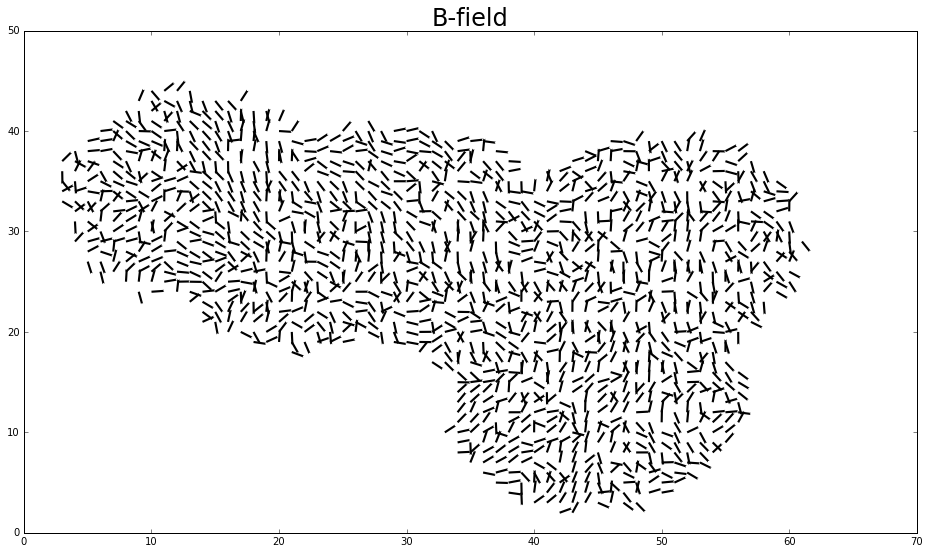

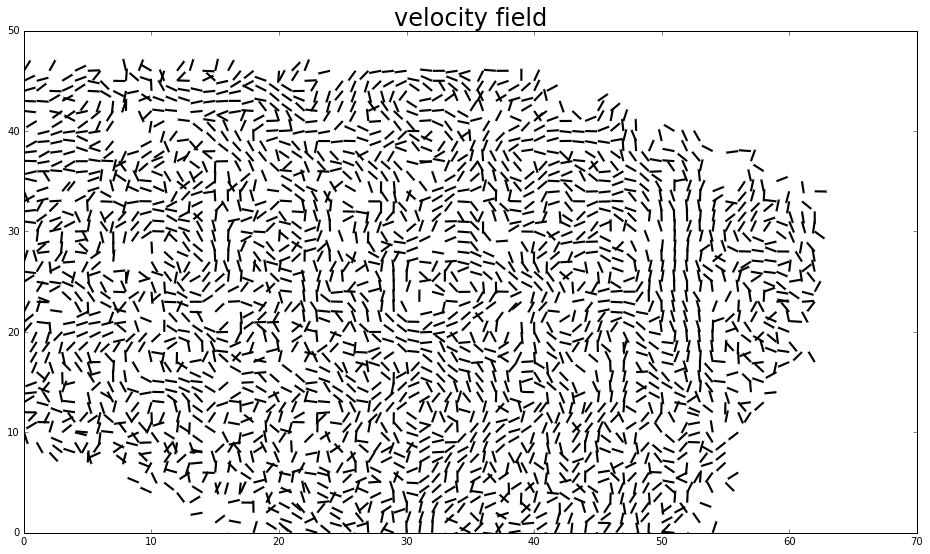

In [35]:
n2068_px, n2068_py = plot_quiver(n2068_p); plt.title('B-field', fontsize=24)
n2068_vx, n2068_vy = plot_quiver(n2068_v); plt.title('velocity field', fontsize=24)

n2068_E, n2068_B, n2068_Epsd, n2068_Bpsd = QU_to_EB(n2068_Q,n2068_U)
n2068_vE, n2068_vB, n2068_vEp, n2068_vBp = xy_to_EB(n2068_vx,n2068_vy)

### RAPS

#### velocity field

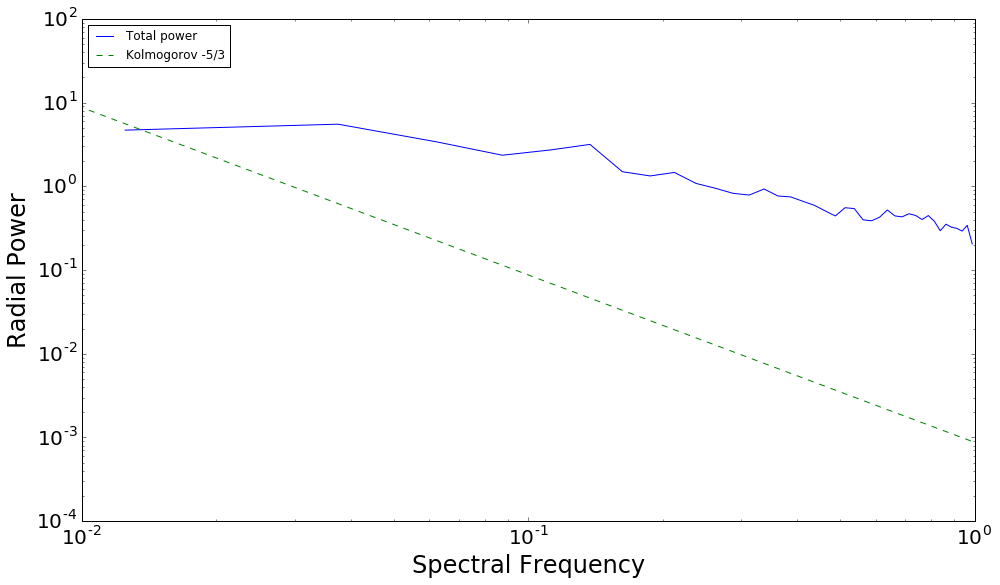

In [16]:
plt.figure(figsize=(16,9))
v_tot, v_tpsd = tot_spec(n2068_vE,n2068_vB,plot=True)
plt.legend(loc='upper left')

#### B-field

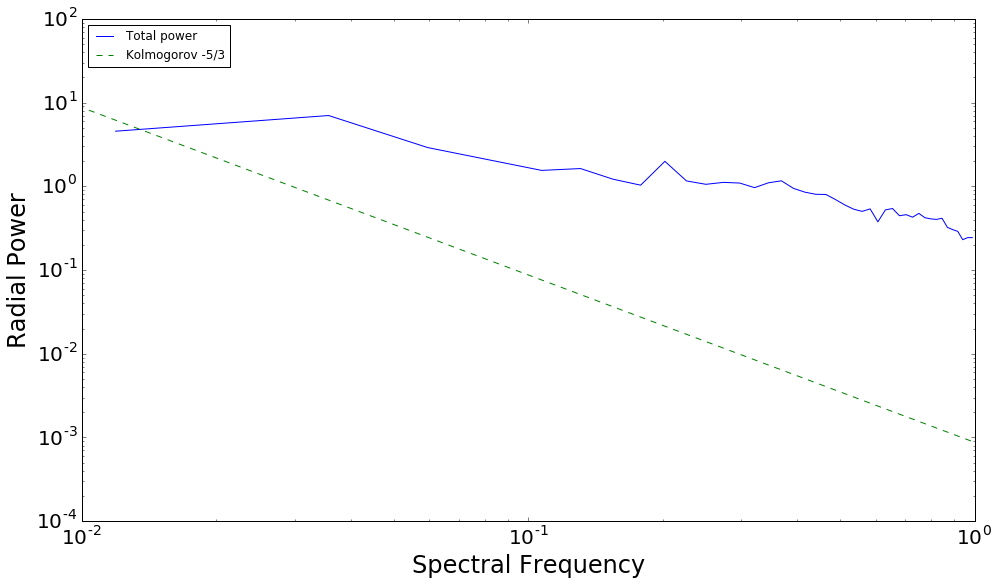

In [17]:
plt.figure(figsize=(16,9))
p_tot, p_tpsd = tot_spec(n2068_E,n2068_B,plot=True)
plt.legend(loc='upper left')

---
## MCMC
Uniform priors for the weights. The third weight is fully determined by the two because they need to sum up to one.

Most results were reproduced for 1000 steps only to save time. They had been tested for 3 chains with 10000 steps but no convergence (no good one) had been found for most of them (except noisefree)

In [27]:
exec(open('./codes/noise_gen.py'))
exec(open('./codes/plot_fit.py'))
exec(open('./codes/mcmc.py'))

In [25]:
def test_out(w):
    ## generate spectra...
    ### data
    rdm_d = rdm_data_v(data_v)
    data_x, data_y = pa2vxvy(rdm_d)
    
    E1, B1, _, _ = xy_to_EB(data_x,data_y)
    data_Tpsd = tot_spec(E1,B1)
    
    ### free field
    weights = []
    for i in range(2):
        weights.append(w[i])
    weights.append(1-np.sum(weights)) ## total summing to unity
    ff = per_sum(size=[50,50],weights=weights,
                 seed=np.random.randint(np.iinfo(np.int32).max))
    #plt.figure(figsize=(12,12))
    #plt.imshow(ff,origin="lower"); plt.colorbar()
    
    ff_x, ff_y = pa2vxvy(ff)
    E1f, B1f, _, _ = xy_to_EB(ff_x,ff_y)
    ff_Tpsd = tot_spec(E1f,B1f,plot=True)
    
    
    plot_quiver(ff,figsize=(10,10),s=30)
    return data_Tpsd[1],ff_Tpsd[1]

#### The "model" - curl-noise with three scales

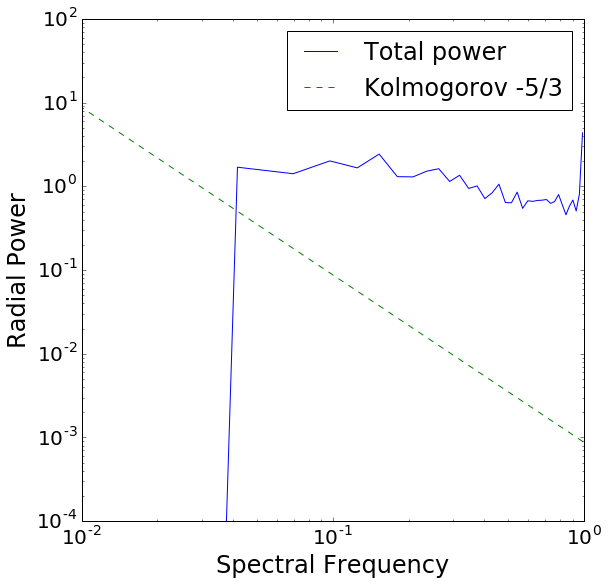

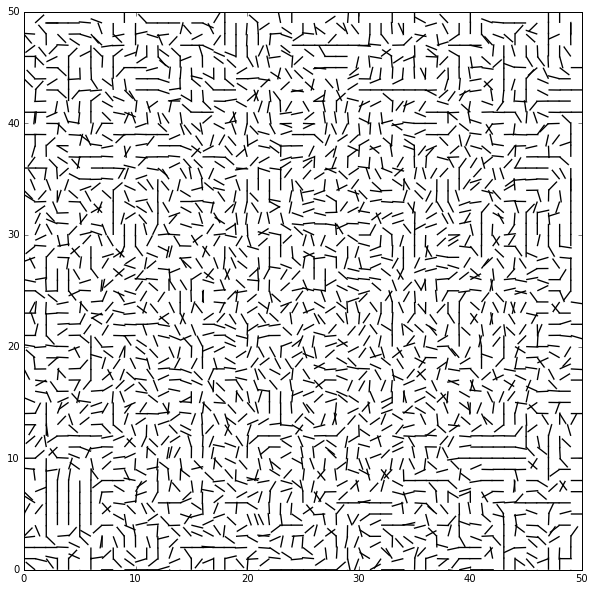

In [29]:
plt.figure(figsize=(9,9))
ww = np.array([1,0,0])
dpsd,fpsd = test_out(ww)

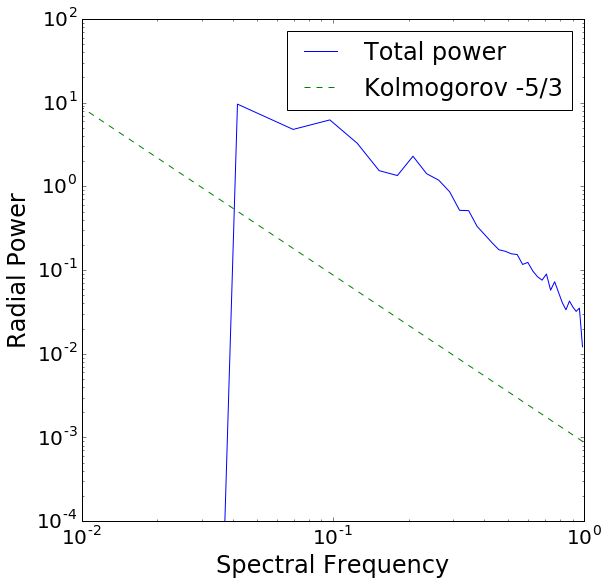

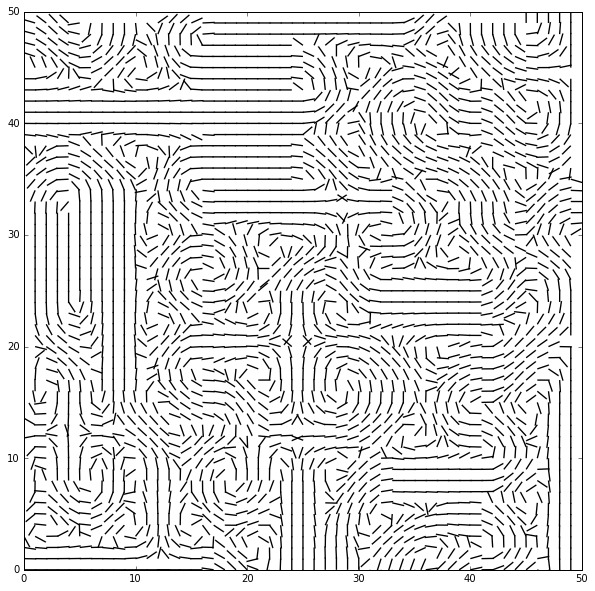

In [31]:
plt.figure(figsize=(9,9))
ww = np.array([0.,1.])
dpsd,fpsd = test_out(ww)

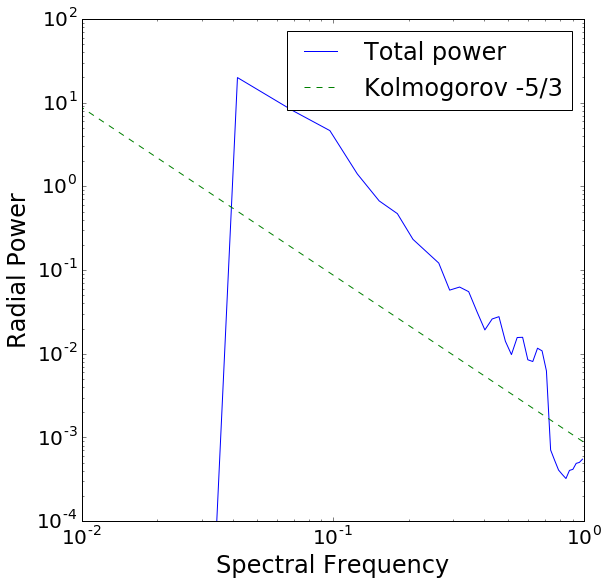

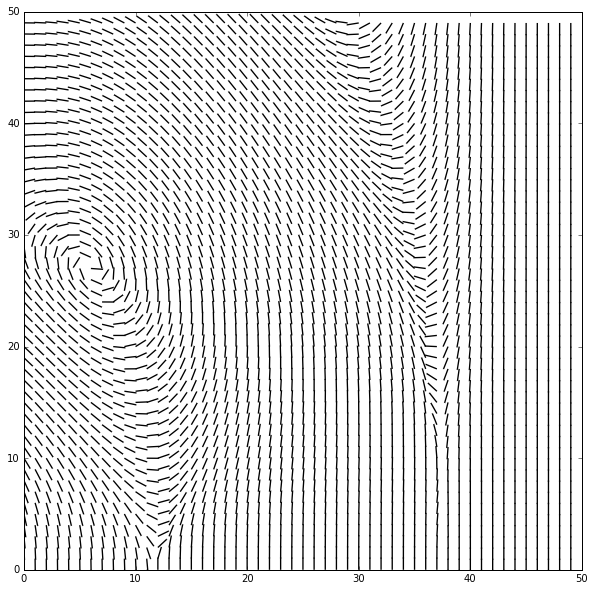

In [32]:
plt.figure(figsize=(9,9))
ww = np.array([0.,0.])
dpsd,fpsd = test_out(ww)

---
### CSD results: bad

#### velocity field

In [102]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]
prspace_v = lmc.ParameterSpace([w[0],w[1]], log_post_v_csd)

In [103]:
data_v = n2068_pa

Nchains = 1
Nsteps = 10000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_v, ch)
    %time v(1,Nsteps)

CPU times: user 37min 8s, sys: 7.52 s, total: 37min 16s
Wall time: 37min 21s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


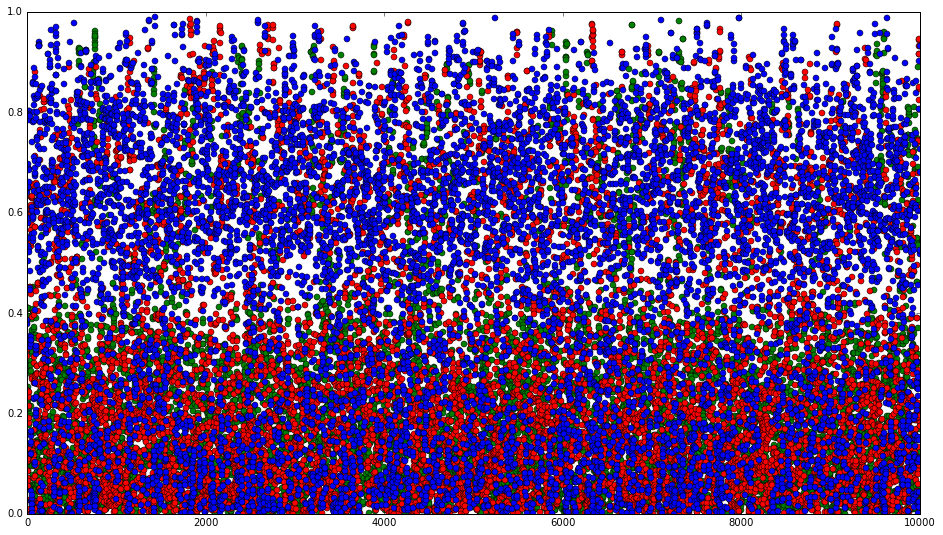

In [104]:
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

In [105]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_v]]).T

In [106]:
oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

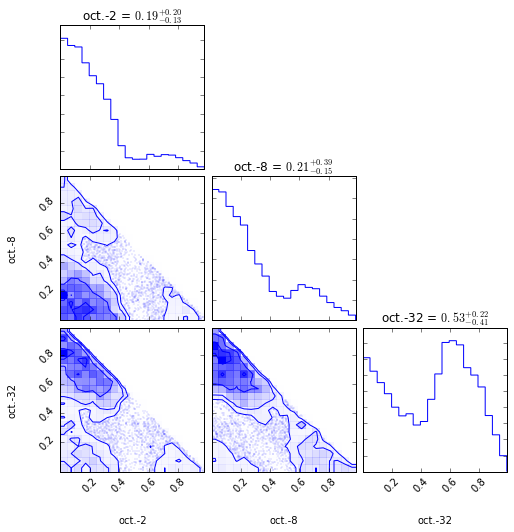

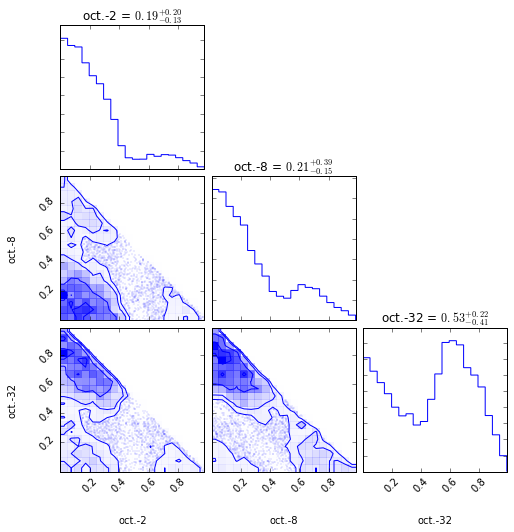

In [107]:
import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_v]+['oct.-32'], color='b',show_titles=True)

#### B-field

In [108]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]

prspace_p = lmc.ParameterSpace([w[0],w[1]], log_post_p_csd)

In [109]:
data_p = n2068_Q,n2068_U

Nchains = 1
Nsteps = 10000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_p, ch)
    %time v(1,Nsteps)

CPU times: user 35min 20s, sys: 6.62 s, total: 35min 27s
Wall time: 35min 30s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


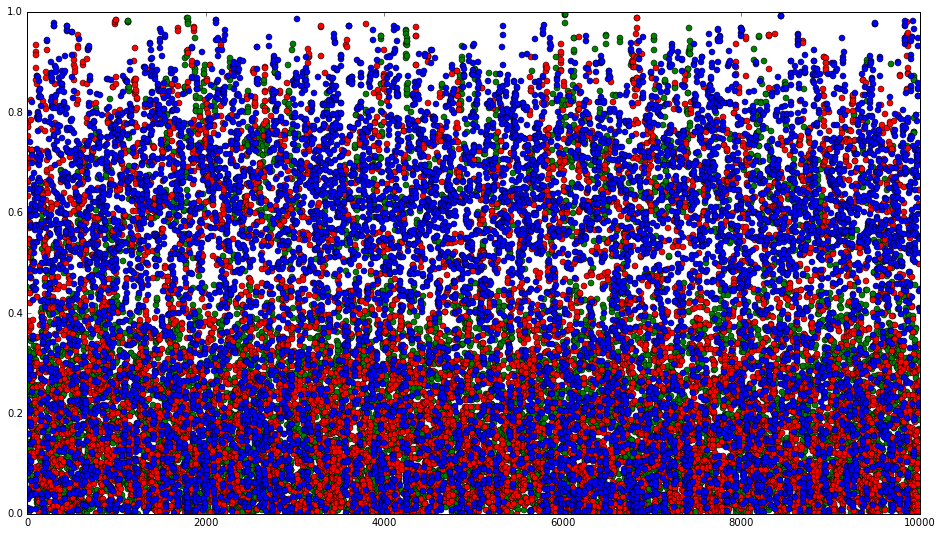

In [110]:
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

In [111]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_p]]).T

In [112]:
oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

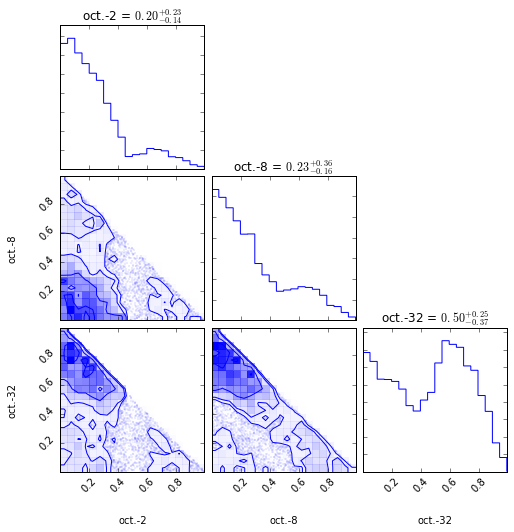

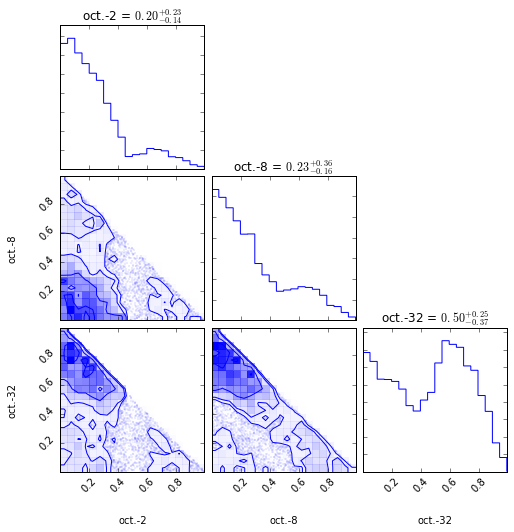

In [ ]:
import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_p]+['oct.-32'], color='b',show_titles=True)

---
### chi-sq noiseless (did not insert noises to data)

#### velocity field

In [54]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]
prspace_v = lmc.ParameterSpace([w[0],w[1]], log_post_v_chi_noiseless)

In [55]:
data_v = n2068_pa

Nchains = 1
Nsteps = 1000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_v, ch)
    %time v(1,Nsteps)

CPU times: user 4min 31s, sys: 1.25 s, total: 4min 32s
Wall time: 4min 33s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


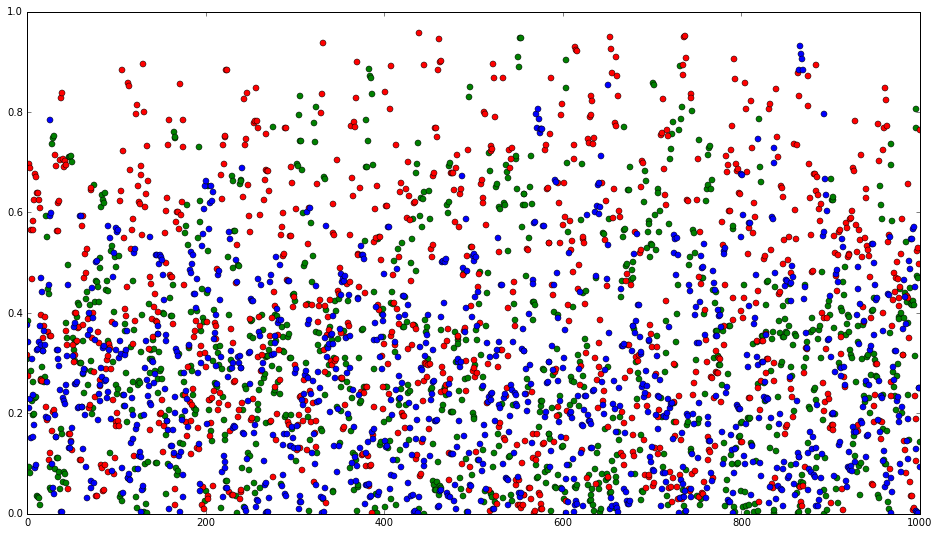

In [56]:
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

In [57]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_v]]).T

In [58]:
oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

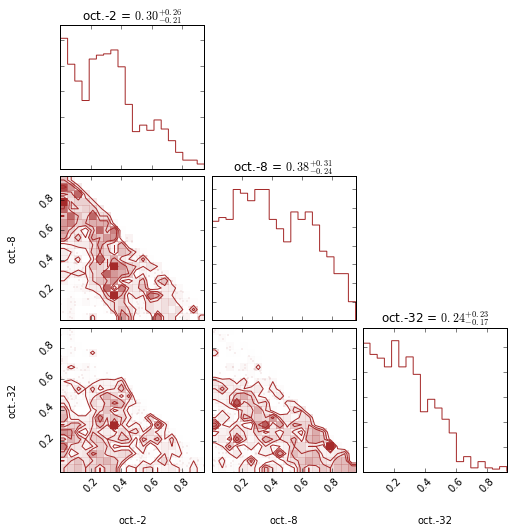

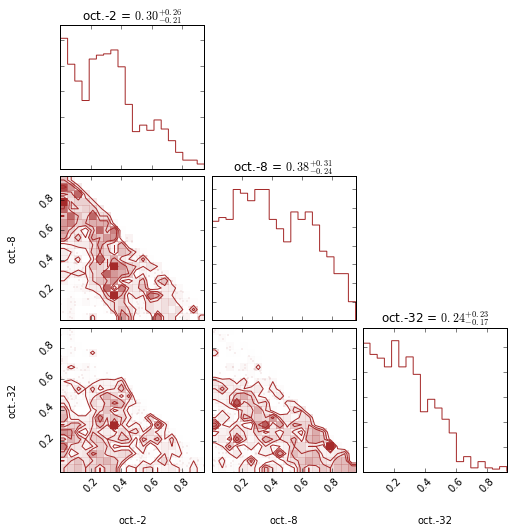

In [59]:
import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_v]+['oct.-32'], color='brown',show_titles=True)

#### B-field

In [60]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]

prspace_p = lmc.ParameterSpace([w[0],w[1]], log_post_p_chi_noiseless)

data_p = n2068_Q,n2068_U

Nchains = 1
Nsteps = 1000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_p, ch)
    %time v(1,Nsteps)

CPU times: user 4min 8s, sys: 1.07 s, total: 4min 9s
Wall time: 4min 10s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


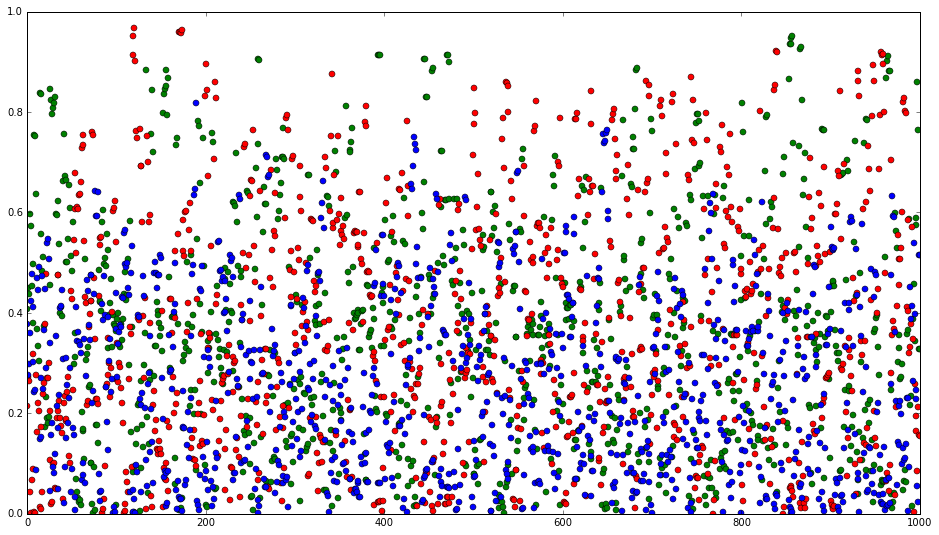

In [61]:
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

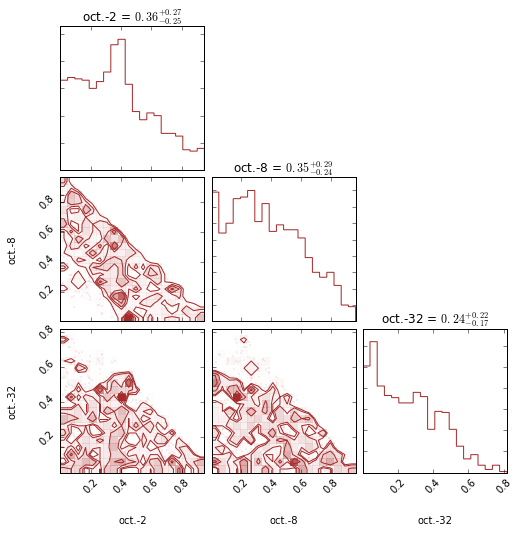

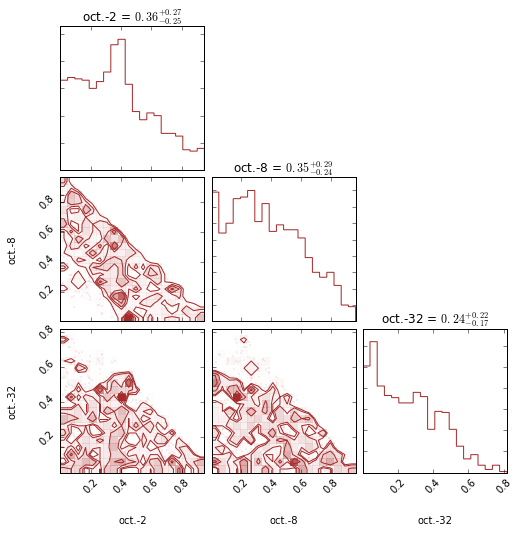

In [62]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_p]]).T

oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_p]+['oct.-32'], color='brown',show_titles=True)

---
## chi-sq with noise (noisy)

#### velocity field

CPU times: user 4min 14s, sys: 1.5 s, total: 4min 15s
Wall time: 4min 17s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


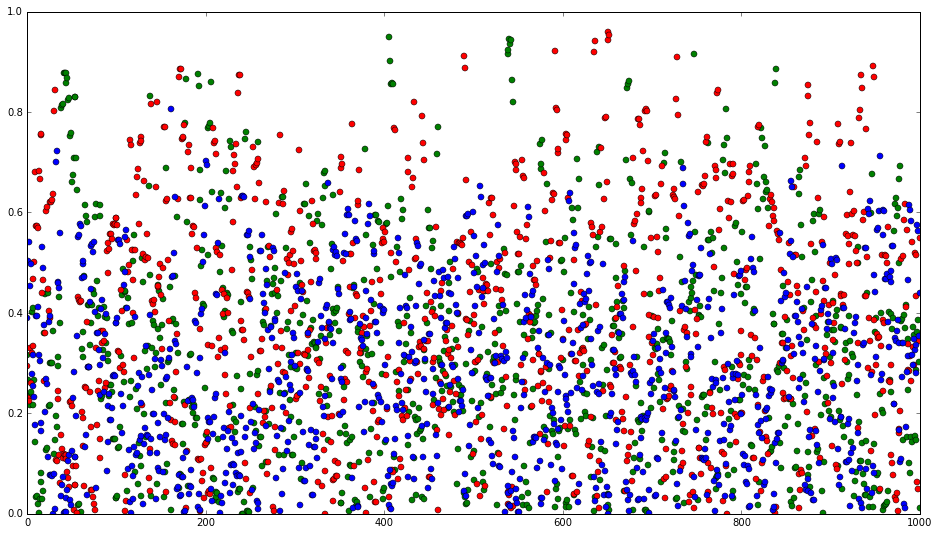

In [64]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]
prspace_v = lmc.ParameterSpace([w[0],w[1]], log_post_v_chi)

data_v = n2068_pa

Nchains = 1
Nsteps = 1000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_v, ch)
    %time v(1,Nsteps)
    
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

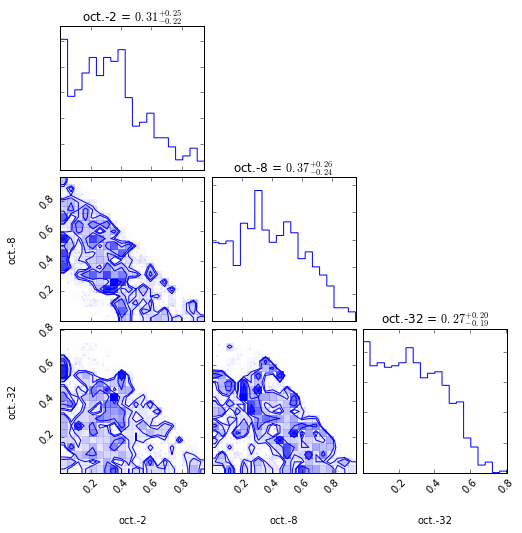

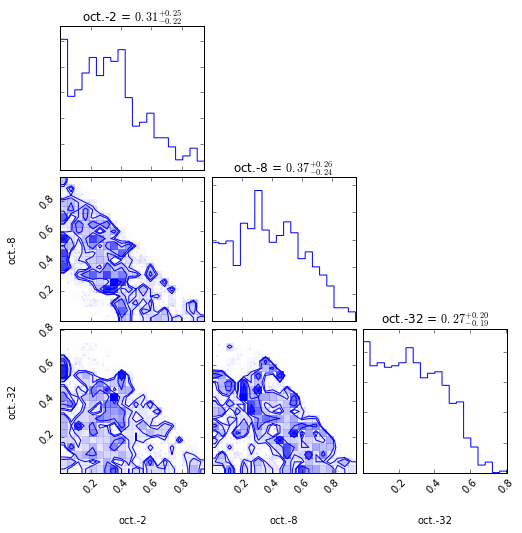

In [65]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_v]]).T

oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_v]+['oct.-32'], color='b',show_titles=True)

#### B-field

CPU times: user 4min 14s, sys: 1.17 s, total: 4min 15s
Wall time: 4min 16s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


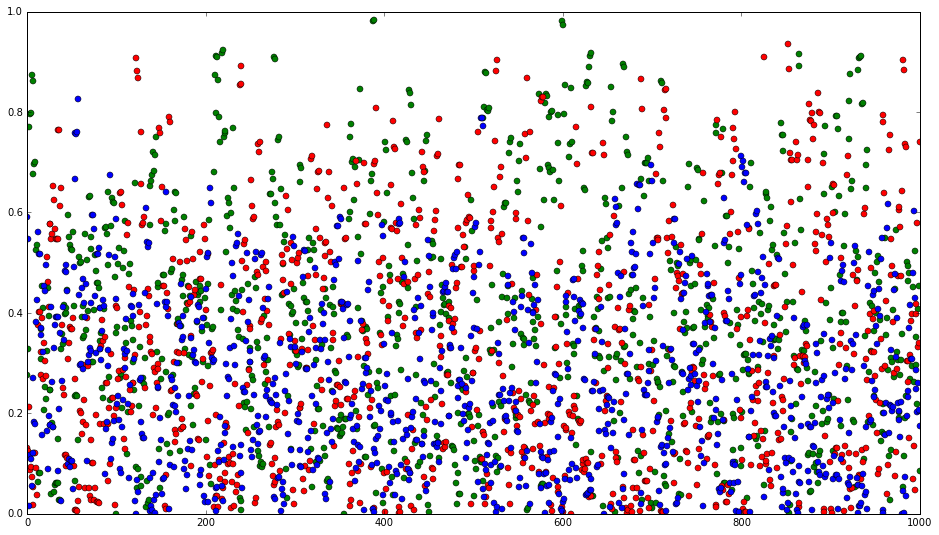

In [66]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]

prspace_p = lmc.ParameterSpace([w[0],w[1]], log_post_p_chi)

data_p = n2068_Q,n2068_U

Nchains = 1
Nsteps = 1000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_p, ch)
    %time v(1,Nsteps)
    
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

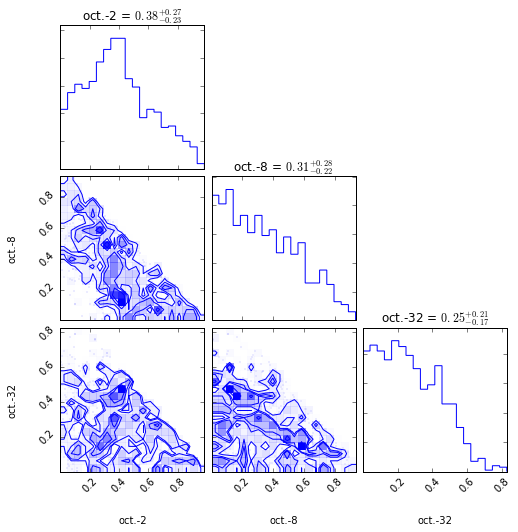

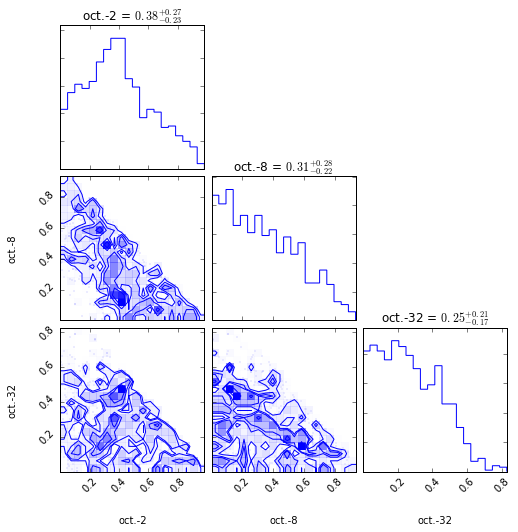

In [68]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_p]]).T

oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_p]+['oct.-32'], color='b',show_titles=True)

---
## chi-sq with fixed seeds (noisefree)
_The fake convergence_

#### velocity field

CPU times: user 15min 12s, sys: 4.97 s, total: 15min 17s
Wall time: 15min 23s


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


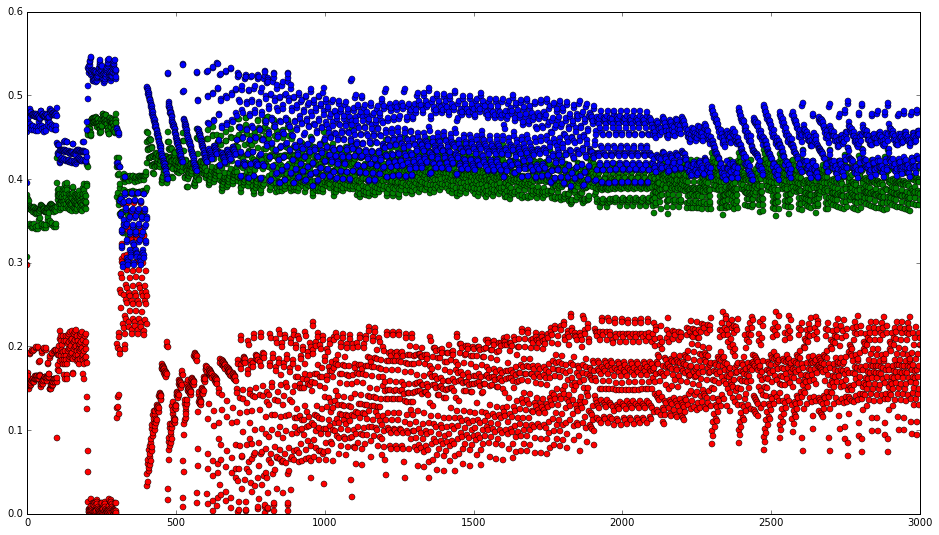

In [76]:
w = [lmc.Parameter(0.3, 1e-2, 'oct.-2'), lmc.Parameter(0.3, 1e-2, 'oct.-8')]
prspace_v = lmc.ParameterSpace([w[0],w[1]], log_post_v_chi_fixseed)

data_v = n2068_pa

Nchains = 1
Nsteps = 3000
chains = [lmc.dictBackend() for j in range(Nchains)]
for ch in chains:
    v = lmc.Vehicle(prspace_v, ch)
    %time v(1,Nsteps)
    
plt.figure(figsize=(16,9))
for ch in chains:
    plt.plot(ch['oct.-2'], 'go', ms=6.0,label='Small')
    plt.plot(ch['oct.-8'], 'ro', ms=6.0,label='Medium')
    plt.plot(np.ones(len(ch['oct.-2'])) - ch['oct.-8'] -ch['oct.-2'], 'bo', ms=6.0,label='Large (dependent)')

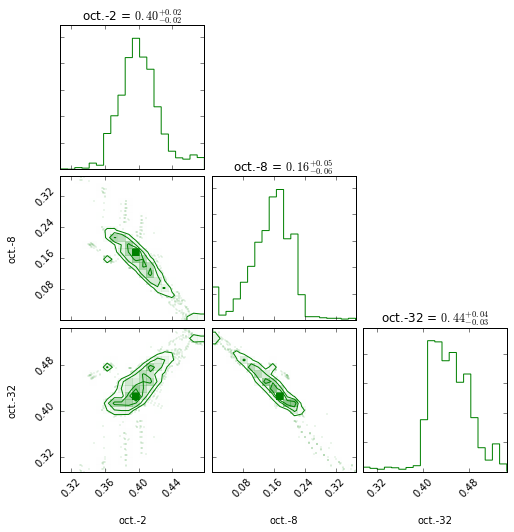

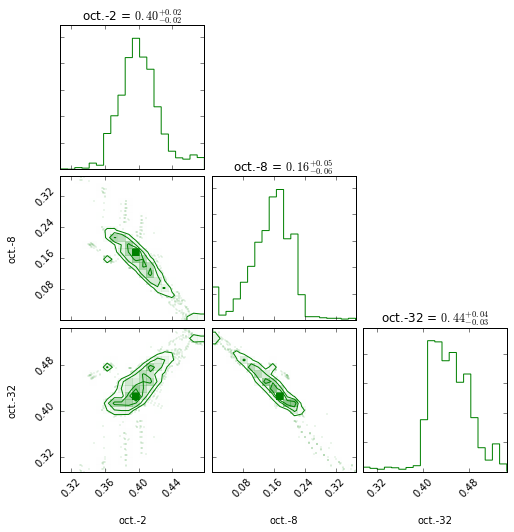

In [77]:
burn=0
post = np.array([np.concatenate([np.array(ch[k])[np.arange(burn, len(ch[k]))] 
                                 for ch in chains]) 
                 for k in [p.name for p in prspace_v]]).T

oct32 = np.array([np.ones(len(ch['oct.-2']))-ch['oct.-8']-ch['oct.-2']])
post = np.vstack((post.T,oct32)).T

import corner
corner.corner(post[:,range(3)], labels=[p.name for p in prspace_v]+['oct.-32'], color='g',show_titles=True)

---
## Evidence - B-field described by model or velocity field
* **Bayesian evidence for the model**: draw samples from prior (uniform)
* **Frequentist evidence**: draw "new" observations from both B-field and velocity field and asses their similarity

In [33]:
N_samples = 2000

In [131]:
evid(w_prior)

sampling...: 0
sampling...: 100
sampling...: 200
sampling...: 300
sampling...: 400
sampling...: 500
sampling...: 600
sampling...: 700
sampling...: 800
sampling...: 900
sampling...: 1000
sampling...: 1100
sampling...: 1200
sampling...: 1300
sampling...: 1400
sampling...: 1500
sampling...: 1600
sampling...: 1700
sampling...: 1800
sampling...: 1900


/Library/Python/2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in true_divide


(1009.5785361660453,
 1836.9830455638685,
 0.95903772541073928,
 0.96664182003911603)